# Evrişimli Sinir Ağları (CNN) ile Görüntü Sınıflandırma 

Bu başlık altında, spor ayakkabı ve gömlek gibi giysi görüntülerini sınıflandırmak için bir sinir ağı oluşturup eğiteceğiz.

Amaç, her ayrıntıyı yakalamak değil, bir TensoFlow projesinin genel anlamını kavramaktır.

Bu kılavuz, TensorFlow'da modeller oluşturmak ve eğitmek için üst düzey bir API olan [tf.keras](https://www.tensorflow.org/guide/keras) 'ı kullanır.

## İçe Aktarma İşlemlerinin Yapılması

Veri kümelerini indirmeyi, erişmeyi basitleştiren ve çalışmak için birçok veri kümesi sağlayan bir API olan TensorFlow Veri Kümelerine ([TensorFlow Datasets](https://www.tensorflow.org/datasets/)) ihtiyacımız olacak.

In [1]:
import tensorflow as tf

# TensorFlow veri setlerinin içeri aktarılması
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Diğer yardımcı kütüphaneler
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Bu başlık altında, 10 kategoride 70000 gri tonlamalı görüntü içeren [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) veri kümesini kullanıyoruz. Görüntüleri aşağıda görüldüğü gibi düşük çözünürlükte (28 x 28 piksel) olan ve her bir ayrı ayrı giyim eşyaları olan görsellerdir.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

**Fashion MNIST**, genellikle bilgisayarlı görü için makine öğrenimi programlarının "Merhaba Dünya!"sı (Hello World!) olarak kullanılan klasik [MNIST](http://yann.lecun.com/exdb/mnist/) veri setinin yerini alacak şekilde tasarlanmıştır. MNIST veri seti, burada kullanacağımız giyim eşyalarıyla aynı formatta el yazısı rakamlarından oluşan (0, 1, 2, vb.) görüntüleri de içerir.

Bu kılavuz, Fashion MNIST'i çeşitlilik için kullanır çünkü bu normal MNIST veri setinden biraz daha zorlayıcı problemler içerir. Her iki veri kümesi de küçüktür ve bir algoritmanın beklendiği gibi çalışıp çalışmadığını kontrol etmek (doğrulamak) için kullanılır. Kodu test etmek ve hata ayıklamak için iyi bir seçimdir.

Sinir ağımızı eğitmek için 60000 görüntü ve ağın görüntüleri sınıflandırmayı ne kadar doğru yaptığını değerlendirmek için 10000 görüntü kullanacağız. Fashion MNIST veri setine [Datasets](https://www.tensorflow.org/datasets) API sayesinde doğrudan TensorFlow üzerinden erişebiliriz.


In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMWJE2C/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteMWJE2C/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Veri kümesini yüklediğimizde eğitim ve test veri kümesinin yanı sıra meta verilerini de geri döndürür.

* Modeli `train_dataset` kullanarak eğiteceğiz.
* Modeli `test_dataset` kullanarak test edeceğiz.

Görüntüler, piksel değerleri `0-255` aralığında olan 28 x 28 bir dizidir. Etiketler ise `0-9` aralığında bir tam sayı dizisidir. Bu sayılar, görüntünün temsil ettiği giysi sınıfına karşılır gelir:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Her görüntü tek bir etiketle eşleşir. Sınıf adları veri kümesine dahil edilmediği inin, daha sonra görüntüleri çizerken kullanmak üzeri onları saklayalım : 


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Verileri Keşfedelim

Modeli eğitmeden önce veri kümesinin biçimini inceleyelim. Aşağıdakiler, eğitim setinde 60000 ve test setinde ise 10000 görüntü olduğunu göstermektedir.

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Eğitim veri setimizdeki örnek sayımız : {}".format(num_train_examples))
print("Test veri setimizdeki örnek sayımız   : {}".format(num_test_examples))

Eğitim veri setimizdeki örnek sayımız : 60000
Test veri setimizdeki örnek sayımız   : 10000


## Verilerin Ön İşlenmesi

Görüntü verilerindeki her pikselin değer `0-255` aralığında bir tam sayıdır. Modelin düzgün çalışması için bu değerlerin `0-1` aralığına normalleştirilmesi gerekir. Yani burada bir normelleştirme işlevi (fonksiyonu) oluşturuyoruz ve ardından bunu hem eğitim hem de test veri setimizdeki her görüntüye uyguluyoruz.


In [5]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# map işlevi, normelleştirmeyi eğitim ve test veri setimizdeki her öğeye uygular.
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Veri setini ilk kullandığımızda, görüntüler diskten yüklenecektir.
# Ön belleğe alma, onları bellekte tutacak ve eğitimi daha hızlı hale getirecektir.
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### İşlenen Verilere Göz Atalım

Nasıl göründüklerini görmek için `matplotlib` kütüphanesini kullanarak resimlerini çizelim.

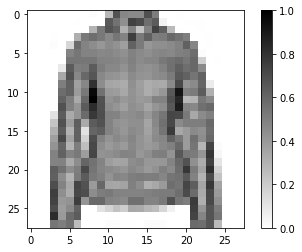

In [6]:
# Tek bir görüntü alır ve yeniden şekillendirir. Renk boyutunu kaldırır.
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Resmi çizdirelim.
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Şimdi de eğitim setindeki ilk 25 resmi görüntüleyelim ve her resmin altında sınıf adını görüntüleyelim. Verilerin doğru biçimde olduğunu doğruladıktan sonra ağı oluşturmaya ve ağımızı eğitmeye geçebiliriz.

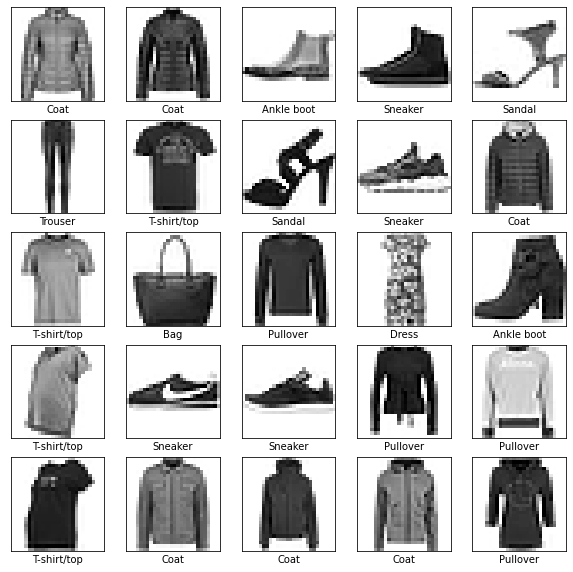

In [7]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Modelin Oluşturulması

Sinir ağının oluşturulması, modelin katmanlarının ayarlanması ve ardından modelin derlenmesi aşamalarının bütünüdür.

### Katmanların Ayarlanması

Bir sinir ağının temel yapı taşı katmanlardır (*layer*). Bir katman, kendisini besleyen (girdi olarak gelen) verilerden bir temsil çıkarır.

Derin öğrenmenin çoğı, basit katmanların birbirine zincirlenmesinden oluşmaktadır. `tf.keras.layers.Dense` gibi çoğu katman, eğitim sırasında ayarlanan yani öğrenilen (*learned*) dahili parametrelere sahiptir.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Bu ağın katmanları şu şekildedir:

* **Evrişim (convolutions) :** `tf.keras.layers.Conv2D and MaxPooling2D` — Ağ, iki çift Conv/MaxPool ile başlar. İlk katman, girdi görüntüsüne uygulanan orijinal görüntü boyutunu koruyan ve 32 çıktı (evrişimli) görüntü oluşturan bir Conv2D filtresidir. Bundan sonra, bir MaxPooling2D (2,2) kullanılarak 32 çıktının boyutu 2'lik bir adımla küçültülür. Sonraki Conv2D'de ayrıca bir (3,3) çekirdeğe sahiptir. 32 görüntüyü girdi olarak alır ve 64 çıktı oluşturur. MaxPooling2D katmanı tarafından boyut olarak tekrar küçültülür.

* **Çıktı (output) :** `tf.keras.layers.Dense` — 128 nörondan ve 10 düğümlü bir softmax katmanıdır. Her düğüm bir giysi sınıfını temsil etmektedir. Önceki katmanda olduğu gibi, son katman önceki katmandaki 128 düğümden girdi alır ve görüntünün o sınıfa ait olma olasılığını temsil eden `0-1` arası bir değer verir. 10 düğümdeki değerlerin toplamı 1 olmalıdır.




> Not: `softmax` aktivasyonu ve `SparseCategoricalCrossentropy()` kullanımında sorunlar vardı ve bunlar `tf.keras` modeli tarafından düzeltildi. Genel olarak daha güvenli bir yaklaşım olarak `SparseCategoricalCrossentropy(from_logits=True)` ile aktivasyon fonskiyonu olmadan doğrusal bir çıktı kullanılır.

### Modelin Derlenmesi

Model eğitime hazır olmadan önce birkaç ayara daha ihtiyacı var. Bunlar modelin derleme adımı sırasında eklenir:

* Kayıf Fonksiyonu (*Loss Function*) — Modelin çıktıların istenen çıktıdan ne kadar uzakda olduğunu ölçmek için bir algoritmadır. Eğitimin amacı, bu kaybı ölçmektir.

* Optimize Edici (*Optimizer*) — Kaybı en aza indirmek için modelin iç parametrelerini ayarlamada kullanılan bir algoritmadır.

* Metrikler (*Metrics*) — Eğitim ve test adımlarını izlemek için kullanılır. Aşağıdaki kod bloğunda metrik olarak `accuracy` yani doğruluk metriği kullanılmıştır.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Modelin Eğitilmesi

İlk olarak, eğitimm ve veri setimiz için yineleme davranışını tanımlarız:

1. `dataset.repeat()` öğesini belirterek sonsuza kadar tekrarlarız. (Aşağıdaki `epochs` parametresi, ne kadar süreyle eğitim gerçekleştireceğimizi sınırlar.)

2. `dataset.shuffle(60000)` sırayı rastgele olarak ayarlar, böylece modelimiz örneklerin sırasından dolayı hiçbir şey öğrenmemiş olur.

3. `dataset.batch(32)` ise `model.fit` yöntemine, model değişkenlerini güncellerken 32 görüntü ve etiketten oluşan yığınları kullanmasını söyler.

`model.fit` yöntemi çağrılarak eğitim gerçekleştirilir:
1. `train_dataset` kullanarak eğitim verileriyle modelimizi besleriz.
2. Modelimiz görüntüleri ve etiketleri ilişkilendirmeyi öğrenir.
3. `epochs = 5` parametresi, eğitim veri kümesi ile eğitimin 5 tam yinelenmesi ile sınırlar, yani model tplam 5* 60000 = 300000 girdi alır.




In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [11]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 90s 44ms/step - loss: 0.3940 - accuracy: 0.8587
Epoch 2/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.2581 - accuracy: 0.9053
Epoch 3/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.2092 - accuracy: 0.9231
Epoch 4/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1834 - accuracy: 0.9323
Epoch 5/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1523 - accuracy: 0.9436
Epoch 6/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1295 - accuracy: 0.9515
Epoch 7/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1075 - accuracy: 0.9596
Epoch 8/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0944 - accuracy: 0.9658
Epoch 9/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0779 - accuracy: 0.9710
Epoch 10/10
1875/1875 [==============================] - 81s 43m

Model ilerlerken, kayıp (loss) ve doğruluk (accuracy) metriklerigörüntüülenir. Bu model, eğitim verilerinde yaklaşık 0.89 (%89) doğruluğa ulaşır.

## Doğruluğun (accuracy) Değerlendirilmesi

Sırada modelin test veri kümesinde nasıl performans gösterdiğini görelim. Doğrulu değerlendirmek için test veri setindeki tüm örnekleri kullanalım.

In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Test veri setinin doğruluk (accuracy) değeri:', test_accuracy)

313/313 [==============================] - 6s 19ms/step - loss: 0.2936 - accuracy: 0.9211
Test veri setinin doğruluk (accuracy) değeri: 0.9211000204086304


Sonuç olarak, test veri setindeki doğruluk eğitim veri setindeki doğruluktan daha küçüktür. Model, `train_dataset` üzerinden eğitildiği için bu tamamiyle normaldir. Model, eğitim sırasında hiç görmediği (yani `test_dataset`) görüntülerle karşılaştığında, performansının düşmesini bekleyebiliriz.

## Tahminlerde Bulunma

Eğitilen modeli bazı görüntüler hakkında tahmin yapmak için kullanabiliriz.

In [13]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [14]:
predictions.shape


(32, 10)

Tahmin, 10 sayıdan oluşan bir dizidir. Bu değerler, görüntünün 10 farklı giysi sınıfından her birine eşleşme durumunun güvenilirliğini (confidence) tanımlar. Hangi etiketin en yüksek güven değerine sahip olduğunu görebiliriz:

In [15]:
np.argmax(predictions[0])

4

Çıktıdan anlaşılacağı gibi, bu görüntünün kaban veya `class_names[4]` olduğundan çok emindir. Bunun doğru olup olmadığını görmek için test etiketini kontrol edebiliriz :

In [16]:
test_labels[0]

4

Verilen çıktı modelimizin tahminini doğrular nitelikte. 10 sınıf tahminlerinin tamamına bakmak için bunun grafiğini çizebiliriz:

In [17]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Hadi sıfırıncı (0.) görüntüye ve tahmin dizisine bakalım :

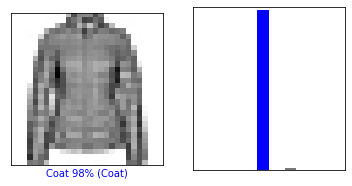

In [18]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

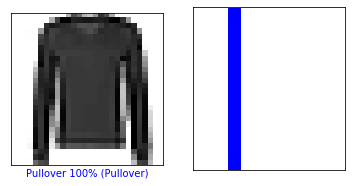

In [19]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Şimdi de tahminlerle birlikte birkaç resim çizelim. Doğru tahmin edilen etiketler mavi ve yanlış tahmin edilenler kırmızı renkle görünecektir. Sayı ise tahmin edilen etiket için yüzdeyi verir. Güven çok yüksek olsa bile yanlış çıkabileceği gerçeğini unutmayalım.

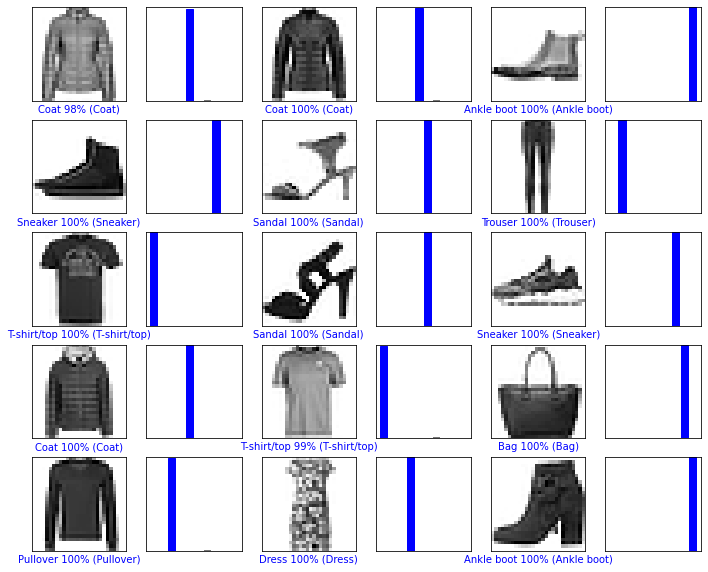

In [20]:
# İlk test görüntülerini, ardından tahmin edilen ve gerçek etiketleri gösterelim.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Şimdi de tek bir görüntü hakkında tahminde bulunmak için eğitmiş olduğumuz modeli kullanalım:

In [21]:
img = test_images[0]
print(img.shape)

(28, 28, 1)


`tf.keras` modelleri, bir seferde bir grup veya örnek koleksiyonu üzerinde tahminler yapmak için optimize edilmiştir. Yani tek bir resim kullanıyor olsak bile onu bir listeye eklememiz gerekir.

In [22]:
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


Ve şimdi resmi tahmin etme zamanı :

In [23]:
predictions_single = model.predict(img)

print(predictions_single)

[[8.02611033e-10 1.92612593e-11 2.93353460e-05 2.49135625e-11
  9.84878242e-01 3.69872020e-13 1.50924595e-02 7.83101535e-12
  2.60765048e-10 2.89143265e-09]]


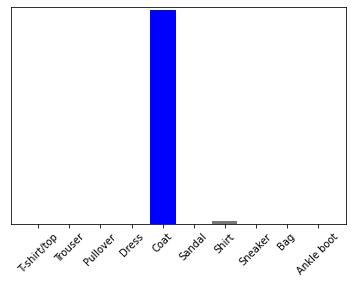

In [24]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model_predict`, veri yığınındaki ger görüntü için bir tane olmak üzere bir liste döndürür. Gruptaki sadece resmimizi ilgilendiren tahminleri alalım :

In [25]:
np.argmax(predictions_single[0])

4

Daha önce de olduğu gibi modelimiz 4 numaralı sınıfı yani kaban etiketini tahmin ediyor.